# Experimental Design Patterns

## Clear cached data if necessary

In [1]:
!rm *.pkl
!rm *.txt
!rm *.png
!rm *.html
!rm -rf embedded-assets
!rm -rf sample_data

rm: cannot remove '*.pkl': No such file or directory
rm: cannot remove '*.txt': No such file or directory
rm: cannot remove '*.html': No such file or directory


## Install packages if necessary

In [2]:
!apt-get install -y graphviz graphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [3]:
!pip install ploomber skorch autogluon.tabular pydot networkx pygraphviz

## Import packages & set global variable values

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import shap

# Sklearn and others
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Global configuration dictionary for synthetic dataset and training settings.
CONFIG = {
    "INITIAL_SAMPLES": 1000,            # Total number of samples in the synthetic dataset
    "TRAIN_SPLIT": 0.7,                 # Proportion for training
    "VALIDATION_SPLIT": 0.15,           # Proportion for validation
    "TEST_SPLIT": 0.15,                 # Proportion for testing
    "KFOLDS": 5,                      # Number of folds for cross-validation
    "NUM_EPOCHS": 100,                # Number of epochs for model training
    "BATCH_SIZE": 32,                 # Batch size for training
    "RANDOM_SEED": 42,                 # Random seed for reproducibility
    "FEATURES": ["Age",
                 "Height",
                 "Weight",
                 "Average Systolic",
                 "Average Diastolic",
                 "Pulse Rate",
                 "Respiratory Rate",
                 "Treatment Type",
                 "Disease Type"]
}

# Set the random seed for reproducibility
np.random.seed(CONFIG["RANDOM_SEED"])

# Check that the dataset splits sum to 1.0
total_split = CONFIG["TRAIN_SPLIT"] + CONFIG["VALIDATION_SPLIT"] + CONFIG["TEST_SPLIT"]
if not np.isclose(total_split, 1.0):
    raise ValueError("The TRAIN_SPLIT, VALIDATION_SPLIT, and TEST_SPLIT must sum to 1.0")

print("Configuration for Synthetic Dataset and Training:")
for key, value in CONFIG.items():
    print(f"{key}: {value}")


Configuration for Synthetic Dataset and Training:
INITIAL_SAMPLES: 1000
TRAIN_SPLIT: 0.7
VALIDATION_SPLIT: 0.15
TEST_SPLIT: 0.15
KFOLDS: 5
NUM_EPOCHS: 100
BATCH_SIZE: 32
RANDOM_SEED: 42
FEATURES: ['Age', 'Height', 'Weight', 'Average Systolic', 'Average Diastolic', 'Pulse Rate', 'Respiratory Rate', 'Treatment Type', 'Disease Type']


## Define Helper Functions

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from typing import Tuple, Dict
from scipy.stats import gaussian_kde
from sklearn.preprocessing import OneHotEncoder

###################################
# Make sure CONFIG is defined somewhere above, e.g.:
# CONFIG = {"RANDOM_SEED": 42, "INITIAL_SAMPLES": 1000, ...}
###################################

def prepare_data(
    df_path: str,
    features: list,
    target: str,
    test_split: float,
    validation_split: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Loads a DataFrame from df_path, extracts 'features' + 'target',
    one-hot encodes any categorical columns (Disease Type, Treatment Type),
    then does train/val/test splits.
    Returns X_train, y_train, X_val, y_val, X_test, y_test as NumPy arrays.
    """
    df = pd.read_pickle(df_path)

    # Ensure the target column actually exists
    if target not in df.columns:
        raise KeyError(
            f"Column '{target}' not found in the DataFrame loaded from {df_path}. "
            "Make sure you have included it if you want to use it as the target."
        )

    # Remove the target from the feature list if it's there by mistake
    if target in features:
        features = [col for col in features if col != target]

    # Extract the target column as a NumPy array
    y = df[target].to_numpy()

    # Subset the columns we want for X
    X_df = df[features].copy()

    # Identify any columns to encode
    possible_cat_cols = ["Disease Type", "Treatment Type"]
    cat_cols = [col for col in possible_cat_cols if col in X_df.columns]

    # One-hot encode if needed
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    if cat_cols:
        cat_data = enc.fit_transform(X_df[cat_cols])
        cat_feature_names = enc.get_feature_names_out(cat_cols)
        X_cat_df = pd.DataFrame(cat_data, columns=cat_feature_names, index=X_df.index)
        X_df.drop(columns=cat_cols, inplace=True)
        X_df = pd.concat([X_df, X_cat_df], axis=1)

    # Convert final features DataFrame to NumPy
    final_feature_names = X_df.columns.to_list()
    X = X_df.to_numpy()

    # Train/val/test split
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=test_split,
        random_state=CONFIG["RANDOM_SEED"]
    )
    relative_val_split = validation_split / (1 - test_split)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=relative_val_split,
        random_state=CONFIG["RANDOM_SEED"]
    )

    return X_train, y_train, X_val, y_val, X_test, y_test, final_feature_names



def explore_data_distributions(df_path: str) -> None:
    """
    Load a DataFrame from a pickle file and create three figures per numeric column:
      1) Histogram separated by Disease Type
      2) Density (KDE) plot separated by Disease Type (skips if subset is singular)
      3) Box plot of side-by-side Disease Type

    Then print summary statistics.
    """
    df = pd.read_pickle(df_path)
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    disease_col = "Disease Type"

    if disease_col not in df.columns:
        print(f"Column '{disease_col}' not found in DataFrame. "
              "Plotting overall distributions only.")
        for col in numeric_cols:
            # Basic histogram
            plt.figure(figsize=(6, 4))
            plt.hist(df[col].dropna(), bins=30, alpha=0.7)
            plt.title(f"Histogram of {col}")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.grid(True)
            plt.show()

            # Basic box plot
            plt.figure(figsize=(6, 4))
            plt.boxplot(df[col].dropna(), vert=True)
            plt.title(f"Box Plot of {col}")
            plt.ylabel(col)
            plt.grid(True)
            plt.show()

        print("Summary statistics:\n", df.describe())
        return

    # Main scenario: disease type in df
    unique_diseases = df[disease_col].dropna().unique()
    for col in numeric_cols:
        # Histograms
        plt.figure(figsize=(8, 5))
        for disease in unique_diseases:
            subset = df.loc[df[disease_col] == disease, col].dropna()
            if len(subset) > 0:
                plt.hist(subset, bins=30, alpha=0.5, label=str(disease))
        plt.title(f"Histogram of {col} by {disease_col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Density (KDE) plots
        plt.figure(figsize=(8, 5))
        for disease in unique_diseases:
            subset = df.loc[df[disease_col] == disease, col].dropna()
            if len(subset) >= 2:
                try:
                    kde = gaussian_kde(subset)
                    x_vals = np.linspace(subset.min(), subset.max(), 200)
                    y_vals = kde(x_vals)
                    plt.plot(x_vals, y_vals, label=str(disease), alpha=0.8)
                except np.linalg.LinAlgError:
                    print(f"Skipping KDE plot for {col}, disease='{disease}' due to singular data subset.")
                    continue
        plt.title(f"Density of {col} by {disease_col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Box plots
        plt.figure(figsize=(8, 5))
        data_for_boxplot = [
            df.loc[df[disease_col] == disease, col].dropna()
            for disease in unique_diseases
        ]
        plt.boxplot(data_for_boxplot, labels=unique_diseases)
        plt.title(f"Box Plot of {col} by {disease_col}")
        plt.xlabel(disease_col)
        plt.ylabel(col)
        plt.grid(True)
        plt.show()

    print("Summary statistics:\n", df.describe())


def apply_dim_reduction(df_path: str, features: list, target_col: str,
                        n_components: int = 2,
                        output_path: str = "synthetic_ehr_reduced.pkl") -> str:
    """
    Load a DataFrame from df_path, apply PCA to the specified features,
    and attach the target column back to the reduced data. Save the result
    to output_path.
    """
    df = pd.read_pickle(df_path)
    X = df[features].values
    pca_model = PCA(n_components=n_components, random_state=CONFIG["RANDOM_SEED"])
    X_pca = pca_model.fit_transform(X)

    pc_cols = [f"PC{i+1}" for i in range(n_components)]
    df_reduced = pd.DataFrame(X_pca, columns=pc_cols, index=df.index)
    df_reduced[target_col] = df[target_col].values
    df_reduced.to_pickle(output_path)

    print(f"Dimensionality reduction complete. PCA explained variance: {pca_model.explained_variance_ratio_}")
    return output_path


def run_kfold_training(X, y, k_folds, model_type="NN",
                       num_epochs=100, batch_size=32):
    """
    Train a model using K-Fold cross-validation.
    Only the first fold is used for demonstration.
    """
    if model_type == "NN":
        from sklearn.neural_network import MLPClassifier
        model = MLPClassifier(max_iter=num_epochs, random_state=CONFIG["RANDOM_SEED"])
    elif model_type == "RF":
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=100, random_state=CONFIG["RANDOM_SEED"])
    elif model_type == "SV":
        from sklearn.svm import SVC
        model = SVC(probability=True, random_state=CONFIG["RANDOM_SEED"])
    else:
        print(f"Model type {model_type} not supported. Defaulting to NN.")
        from sklearn.neural_network import MLPClassifier
        model = MLPClassifier(max_iter=num_epochs, random_state=CONFIG["RANDOM_SEED"])

    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=CONFIG["RANDOM_SEED"])

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train)
        val_score = model.score(X_val, y_val)
        print(f"Validation score for {model_type} on first fold: {val_score:.3f}")
        break

    return model


## Define Ploomber Pipeline Tasks

## Connect Ploomber Tasks to Ploomber DAG

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import inspect
from functools import wraps
import pandas as pd
import numpy as np
import shap
import pickle
from sklearn.decomposition import PCA

def _explore_data_(upstream, product):
    # Assume upstream is a dictionary with a key "generate_data"
    df_path = str(upstream['generate_data'])
    print("Exploring data distributions using file:", df_path)
    explore_data_distributions(df_path)
    # Write a simple confirmation report.
    with open(str(product), "w") as f:
        f.write("Data exploration completed.")
    return str(product)

def _reduce_dim_(upstream, product):
    """
    Perform two separate PCA analyses:
    1) Cardio PCA (3 components) for [Average Systolic, Average Diastolic, Pulse Rate]
    2) Body Mass PCA (2 components) for [Height, Weight]
    Then merge these new components with Age, Respiratory Rate, and Disease Severity.
    Finally, pickle the result at 'product'.
    """

    # Grab the path to the synthetic data from upstream
    df_path = str(upstream['generate_data'])
    output_path = str(product)

    # Load the original data
    df = pd.read_pickle(df_path)

    # 1) Cardio PCA
    cardio_features = ["Average Systolic", "Average Diastolic", "Pulse Rate"]
    cardio_pca = PCA(n_components=3, random_state=CONFIG["RANDOM_SEED"])
    cardio_components = cardio_pca.fit_transform(df[cardio_features])
    print("Cardio PCA explained variance:", cardio_pca.explained_variance_ratio_)

    # 2) Body Mass PCA
    bodymass_features = ["Height", "Weight"]
    bodymass_pca = PCA(n_components=2, random_state=CONFIG["RANDOM_SEED"])
    bodymass_components = bodymass_pca.fit_transform(df[bodymass_features])
    print("Body Mass PCA explained variance:", bodymass_pca.explained_variance_ratio_)

    # Create a DataFrame with the new PCA features + age + respiratory + target
    df_reduced = pd.DataFrame({
        "Cardio PCA 1": cardio_components[:, 0],
        "Cardio PCA 2": cardio_components[:, 1],
        "Cardio PCA 3": cardio_components[:, 2],
        "Body Mass PCA 1": bodymass_components[:, 0],
        "Body Mass PCA 2": bodymass_components[:, 1],
        "Age": df["Age"],
        "Respiratory Rate": df["Respiratory Rate"],
        "Treatment Type": df["Treatment Type"],
        "Disease Type": df["Disease Type"],
        "Disease Severity": df["Disease Severity"]
    })

    # Pickle the final DataFrame
    df_reduced.to_pickle(output_path)
    print(f"Saved final PCA dataset to: {output_path}")

    return output_path


def _generate_synthetic_data_(product):
    """
    Generate synthetic data with guaranteed variance in disease types and numeric columns.
    - Ensures each disease type has at least 'MIN_PER_TYPE' samples, reducing the chance of
      a singular distribution subset.
    - Expands numeric column ranges slightly to ensure variety.
    """

    np.random.seed(CONFIG["RANDOM_SEED"])

    num_samples = CONFIG["INITIAL_SAMPLES"]

    # Define disease types, including 'None' for healthy patients
    disease_types = ['None', 'Cardiovascular', 'Respiratory', 'Neurological']

    # We want to ensure each disease type has at least this many samples:
    MIN_PER_TYPE = 10

    # Step 1: Allocate a base number of samples to each disease category
    # so no category is left with only 1 or 2 rows
    base_allocation = len(disease_types) * MIN_PER_TYPE
    if base_allocation > num_samples:
        raise ValueError(
            f"Not enough total samples ({num_samples}) to allocate {MIN_PER_TYPE} "
            f"to each disease type. Increase INITIAL_SAMPLES or reduce MIN_PER_TYPE."
        )

    # We'll fill the remainder randomly
    remainder = num_samples - base_allocation

    # The leftover is distributed by random choice among disease_types
    random_types_for_remainder = np.random.choice(
        disease_types, size=remainder, replace=True
    )

    # Construct an array for disease types with guaranteed base allocations
    allocated_array = []
    for dt in disease_types:
        allocated_array.extend([dt]*MIN_PER_TYPE)
    # Then add the remainder
    allocated_array = np.array(allocated_array + list(random_types_for_remainder))
    np.random.shuffle(allocated_array)  # shuffle the final array

    # Make sure we ended up with exactly num_samples
    assert len(allocated_array) == num_samples, "Disease type allocation mismatch"

    # Step 2: Decide disease severity
    # - If disease type == 'None', severity = 0
    # - Otherwise, random integer 1 to 5
    severity_array = np.zeros(num_samples, dtype=int)
    mask_has_disease = (allocated_array != 'None')
    severity_array[mask_has_disease] = np.random.randint(1, 6, mask_has_disease.sum())

    # Step 3: Choose treatment types among patients with disease
    treatment_types = ['Medication', 'Surgery', 'Therapy']
    random_treatment = []
    for i, dt in enumerate(allocated_array):
        if dt == 'None':
            # Suppose no formal "treatment" needed if no disease
            random_treatment.append('None')
        else:
            random_treatment.append(np.random.choice(treatment_types))
    random_treatment = pd.Categorical(random_treatment, categories=['None'] + treatment_types)

    # Step 4: Generate numeric columns with (slightly) wider ranges
    # Define a mapping from disease type strings to numeric codes
    disease_type_mapping = {
     'None': 0,
     'Cardiovascular': 1,
     'Respiratory': 2,
     'Neurological': 3
    }

    # Suppose allocated_array is your array of strings (['None','Respiratory',...]) of length num_samples
    # Convert each string to an integer code
    allocated_array_int = np.array([disease_type_mapping[dt] for dt in allocated_array], dtype=int)

    data = {
     'Age': np.random.randint(18, 90, size=num_samples),
     'Height': np.random.uniform(140, 210, size=num_samples),
     'Weight': np.random.uniform(45, 130, size=num_samples),
     'Average Systolic': np.random.uniform(80, 200, size=num_samples),
     'Average Diastolic': np.random.uniform(50, 130, size=num_samples),
     'Pulse Rate': np.random.uniform(50, 110, size=num_samples),
     'Respiratory Rate': np.random.uniform(10, 25, size=num_samples),
     'Treatment Type': random_treatment,
     # Instead of pd.Categorical, directly store the integer codes
     'Disease Type': allocated_array_int,
     'Disease Severity': severity_array
    }

    synthetic_ehr = pd.DataFrame(data, index=pd.RangeIndex(start=1, stop=num_samples+1, name="ID"))
    print("Synthetic EHR Data Preview (first 10 rows):")
    print(synthetic_ehr.head(10))

    # Write the DataFrame to a pickle file
    synthetic_ehr.to_pickle(str(product))
    return synthetic_ehr


def _run_pipeline_task_(upstream, product, model_type):
    # Get the file path from the upstream dependency (should be from reduce_dim)
    upstream_keys = list(upstream.keys())
    if not upstream_keys:
        raise ValueError("No upstream dependency provided.")
    data_path = str(upstream[upstream_keys[0]])

    # Load the data
    data = pd.read_pickle(data_path)
    print("Loaded data preview:")
    print(data.head())

    # Always use the new PCA columns plus Age and Respiratory Rate
    features_used = [
      "Cardio PCA 1",
      "Cardio PCA 2",
      "Cardio PCA 3",
      "Body Mass PCA 1",
      "Body Mass PCA 2",
      "Age",
      "Respiratory Rate",
      "Treatment Type",
      "Disease Type"
    ]

    # Prepare the data using the appropriate feature set and the target column
    X_train, y_train, X_val, y_val, X_test, y_test, final_feature_names = prepare_data(
        data_path, features_used, "Disease Severity",
        CONFIG["TEST_SPLIT"], CONFIG["VALIDATION_SPLIT"]
    )

    # Train the model using the specified model type
    model = run_kfold_training(
        X_train, y_train, CONFIG["KFOLDS"],
        model_type=model_type,
        num_epochs=CONFIG["NUM_EPOCHS"],
        batch_size=CONFIG["BATCH_SIZE"]
    )

    results = {
        "train_data": (X_train, y_train),
        "val_data": (X_val, y_val),
        "test_data": (X_test, y_test),
        "model": model,
        "final_feature_names" : final_feature_names
    }
    print(f"Pipeline execution complete for model {model_type}.")

    # Write the results to a pickle file.
    with open(str(product), "wb") as f:
        pickle.dump(results, f)
    return results



def _extract_features_task_(upstream, product):
    """
    Loads pipeline results, then computes and plots SHAP values for the model
    using KernelExplainer on a sample of X_train. Saves a bar-plot summary
    figure to 'product'.

    Checks:
      - model and train_data exist in results
      - at least 100 samples in X_train
      - dimensional consistency between sample_data, shap_values, and features_np
    """

    # Identify the path to the results file (first upstream dependency).
    results_path = str(list(upstream.values())[0])
    results = pd.read_pickle(results_path)

    # Basic checks that 'model' and 'train_data' exist
    if "model" not in results or "train_data" not in results:
        raise RuntimeError(
            "Results dictionary is missing 'model' or 'train_data'. "
            "Run the pipeline task producing these keys first."
        )

    model = results["model"]
    X_train_np = results["train_data"][0]  # X_train is the first item in train_data

    # Ensure we have enough rows to sample 100 for background
    if X_train_np.shape[0] < 100:
        raise ValueError(
            f"X_train only has {X_train_np.shape[0]} samples; "
            "need at least 100 to select a background subset."
        )

    # Randomly pick 100 samples for background
    np.random.seed(CONFIG["RANDOM_SEED"])
    background_indices = np.random.choice(X_train_np.shape[0], size=100, replace=False)
    background_data = X_train_np[background_indices]

    # Build an explainer using KernelExplainer
    explainer = shap.KernelExplainer(model.predict_proba, background_data)

    # We'll compute SHAP values on the first 100 rows (or fewer if you wish)
    sample_data = X_train_np[:100]
    shap_values = explainer.shap_values(sample_data)

    # If shap_values is a list, we pick the second element for multi-class or the first if single
    if isinstance(shap_values, list):
        if len(shap_values) == 1:
            shap_values_to_plot = shap_values[0]
        else:
            shap_values_to_plot = shap_values[1]
    else:
        shap_values_to_plot = shap_values

    # If we have a 3D shape (multi-class), pick a single class dimension
    if shap_values_to_plot.ndim == 3:
        target_class = 0
        shap_values_for_plot = shap_values_to_plot[:, :, target_class]
    else:
        shap_values_for_plot = shap_values_to_plot

    # Feature names must match the final columns of sample_data
    features_np = results["final_feature_names"]  # a list of 15 names

    # Check dimension consistency
    if sample_data.shape[1] != shap_values_for_plot.shape[1]:
        raise ValueError(
            f"Mismatch: sample_data has {sample_data.shape[1]} columns, "
            f"but shap_values_for_plot has {shap_values_for_plot.shape[1]}. "
            "They must align."
        )
    if sample_data.shape[1] != len(features_np):
        raise ValueError(
            f"Mismatch: sample_data has {sample_data.shape[1]} columns, "
            f"but only {len(features_np)} feature names provided."
        )

    print("SHAP values shape:", shap_values_for_plot.shape)
    print("Sample data shape:", sample_data.shape)

    # Generate the SHAP summary plot (bar chart)
    shap.summary_plot(
        shap_values_for_plot,
        sample_data,
        feature_names=features_np,
        plot_type="bar"
    )

    # Save the current figure to the product file
    plt.savefig(str(product))
    plt.close()

    return str(product)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from ploomber import DAG
from ploomber.tasks import PythonCallable
from ploomber.products import File
import warnings
from IPython.display import display

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="networkx.readwrite.json_graph.node_link"
)

# Create a DAG instance.
dag = DAG(name="A new ploomber pipeline")

# Task 1: Generate synthetic data.
task_generate = PythonCallable(
    _generate_synthetic_data_,
    File("synthetic_ehr.pkl"),
    dag,
    name="generate_data"
)

# New Task: Explore data distributions.
task_explore = PythonCallable(
    _explore_data_,
    File("data_exploration.txt"),
    dag,
    name="explore_data"
)

# New Task: Apply dimensionality reduction.
task_reduce = PythonCallable(
    _reduce_dim_,
    File("synthetic_ehr_reduced.pkl"),
    dag,
    name="reduce_dim"
)

# Task 2: Run pipeline (model training) for each model type.
task_run_nn = PythonCallable(
    _run_pipeline_task_,
    File("results_nn.pkl"),
    dag,
    name="run_pipeline_nn",
    params={"model_type": "NN"}
)

task_run_rf = PythonCallable(
    _run_pipeline_task_,
    File("results_rf.pkl"),
    dag,
    name="run_pipeline_rf",
    params={"model_type": "RF"}
)

task_run_sv = PythonCallable(
    _run_pipeline_task_,
    File("results_sv.pkl"),
    dag,
    name="run_pipeline_sv",
    params={"model_type": "SV"}
)

# (Other model tasks like ShuffleNetV2 and AutoGluon can be added similarly)

# Task 3: Extract important features using SHAP for each model.
task_extract_nn = PythonCallable(
    _extract_features_task_,
    File("shap_summary_nn.png"),
    dag,
    name="extract_features_nn"
)
task_extract_rf = PythonCallable(
    _extract_features_task_,
    File("shap_summary_rf.png"),
    dag,
    name="extract_features_rf"
)
task_extract_sv = PythonCallable(
    _extract_features_task_,
    File("shap_summary_sv.png"),
    dag,
    name="extract_features_sv"
)

# Set Dependencies:
# Data generation
task_generate >> task_explore  # For exploration (optional)
task_generate >> task_reduce   # Dimensionality reduction

# Model training tasks now use the reduced data
task_reduce >> task_run_nn
task_reduce >> task_run_rf
task_reduce >> task_run_sv

# Extraction tasks depend on each corresponding model training task
task_run_nn >> task_extract_nn
task_run_rf >> task_extract_rf
task_run_sv >> task_extract_sv

# Save the DAG Pipeline Design.
dag.plot(output='ploomber_pipeline_structure.png')

  0%|          | 0/9 [00:00<?, ?it/s]

'ploomber_pipeline_structure.png'

## Execute Ploomber DAG

  0%|          | 0/9 [00:00<?, ?it/s]

Synthetic EHR Data Preview (first 10 rows):
    Age      Height      Weight  Average Systolic  Average Diastolic  \
ID                                                                     
1    51  171.804180  111.284775         95.754557         125.694952   
2    72  184.117305   55.048583        117.163005          96.381715   
3    18  157.386853   45.002611        104.215394          93.217381   
4    89  189.382258  105.531649        189.059180          54.025835   
5    55  169.932093   75.310675        171.248008          55.032598   
6    23  170.978186   66.630913        161.167804          64.987743   
7    42  185.452563   46.096285        116.115958          52.597662   
8    34  205.539644   90.925450        102.085373         109.468232   
9    78  144.480444  117.347813        170.774131         107.866424   
10   29  197.732027  126.398690        136.898954          60.884499   

    Pulse Rate  Respiratory Rate Treatment Type  Disease Type  \
ID                        

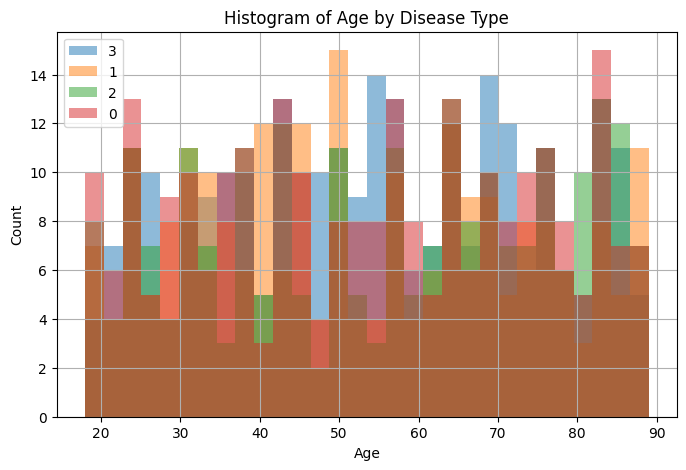

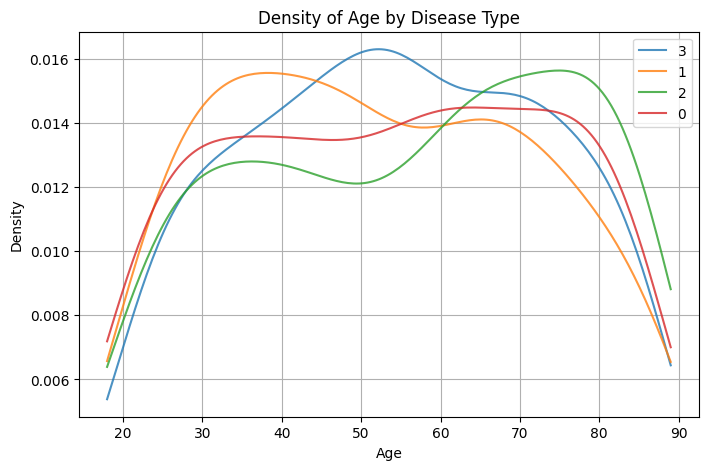

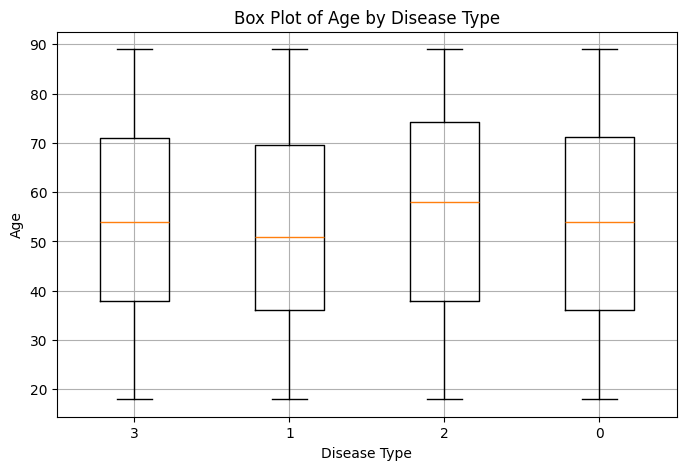

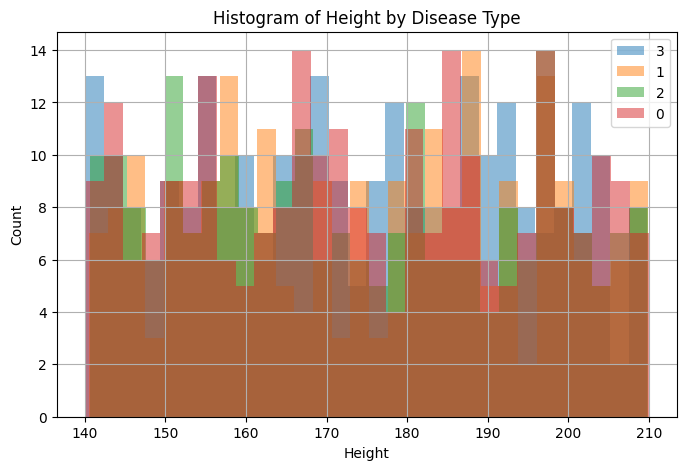

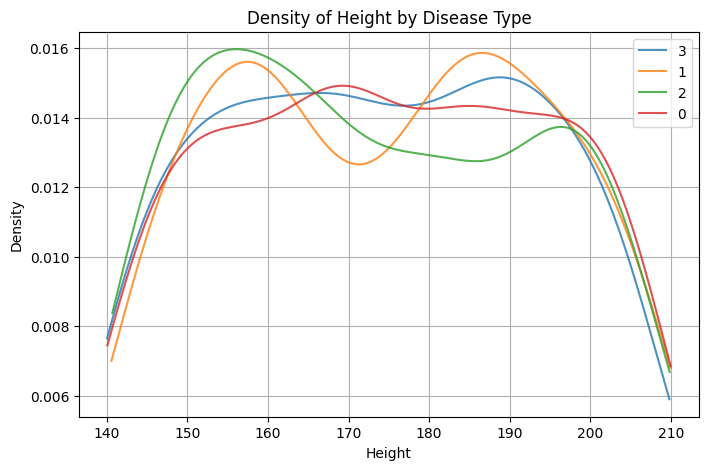

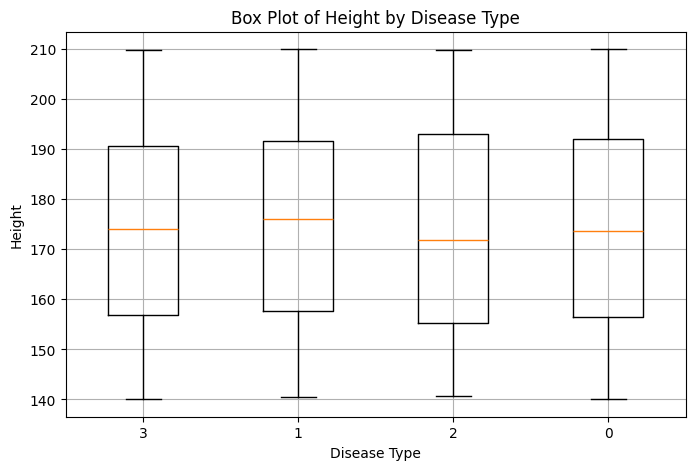

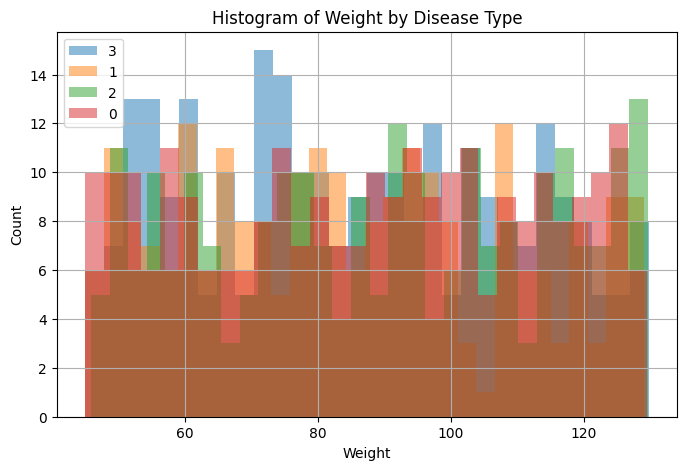

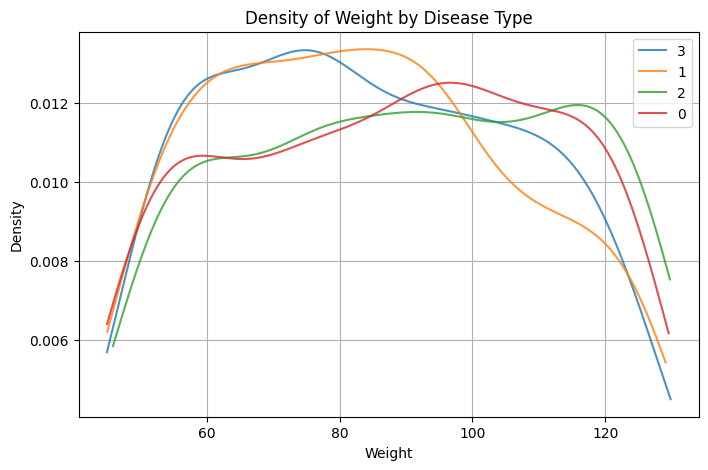

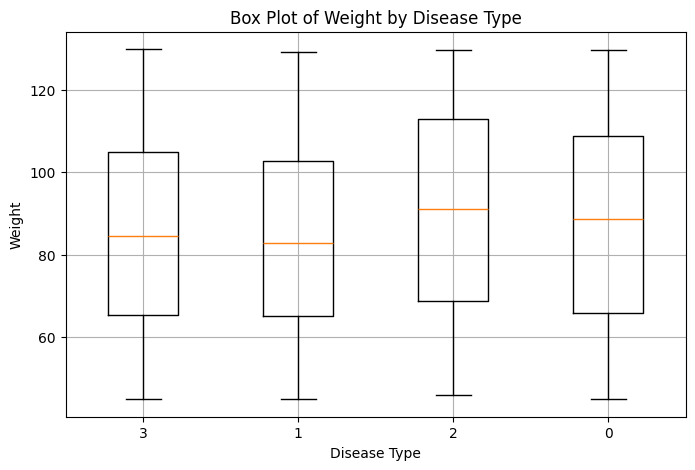

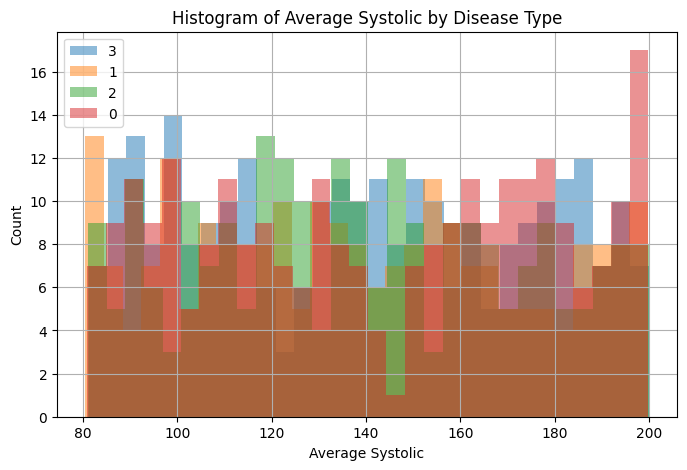

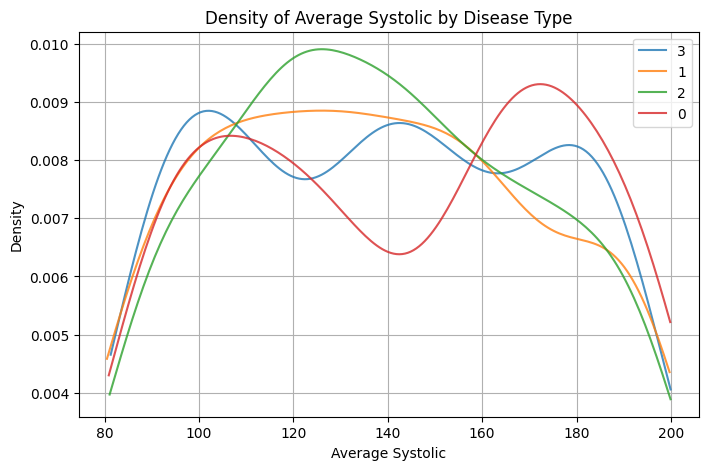

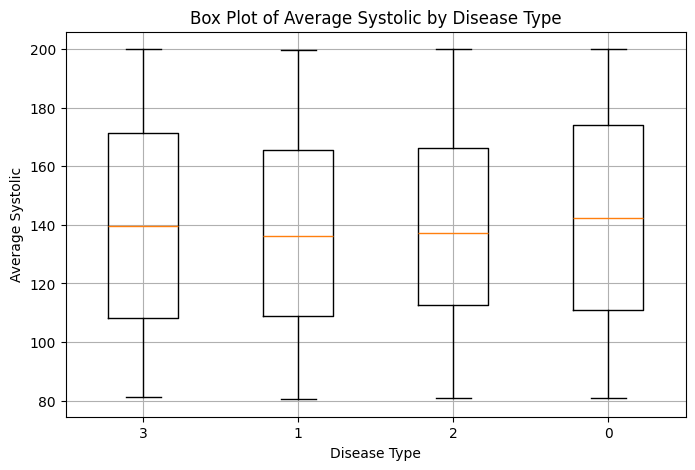

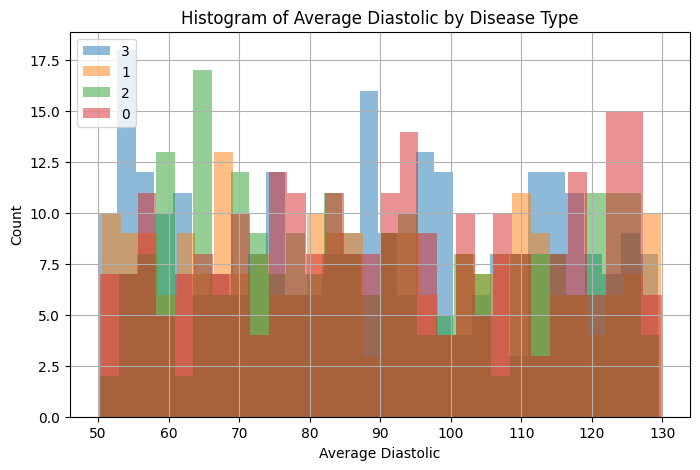

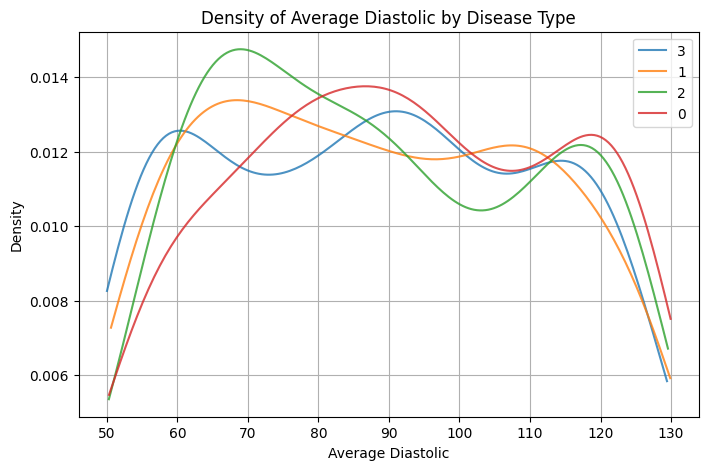

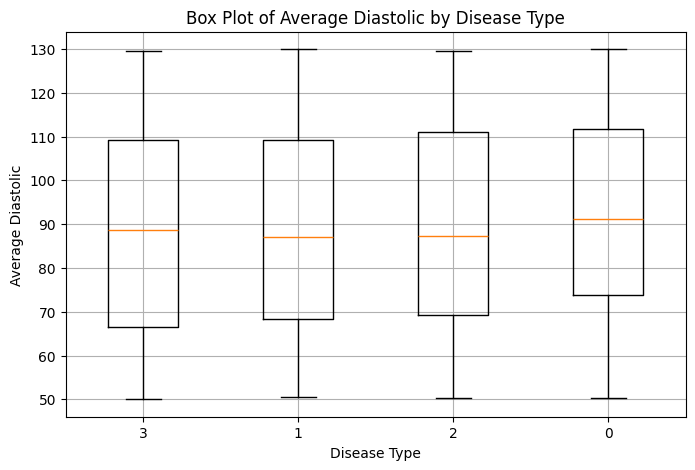

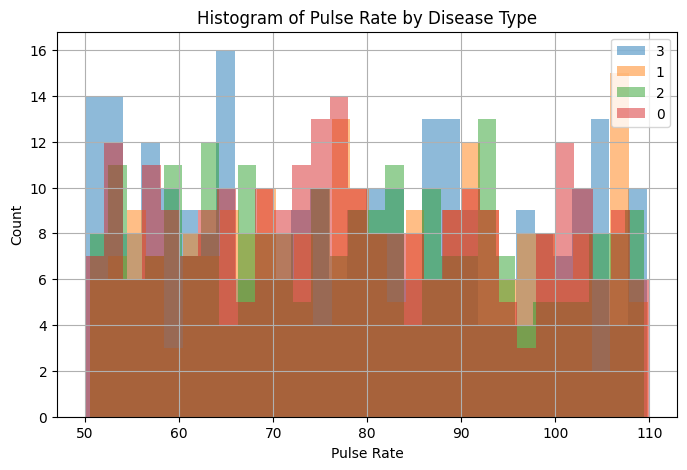

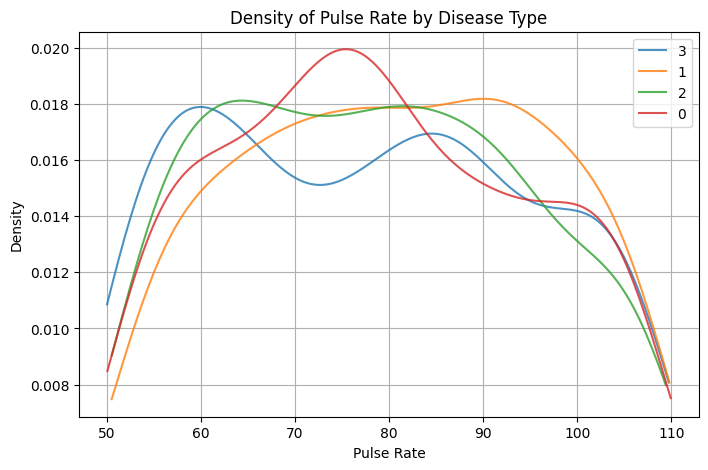

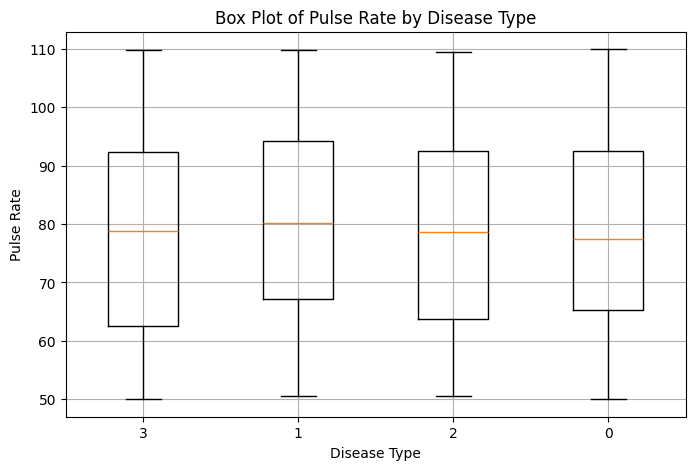

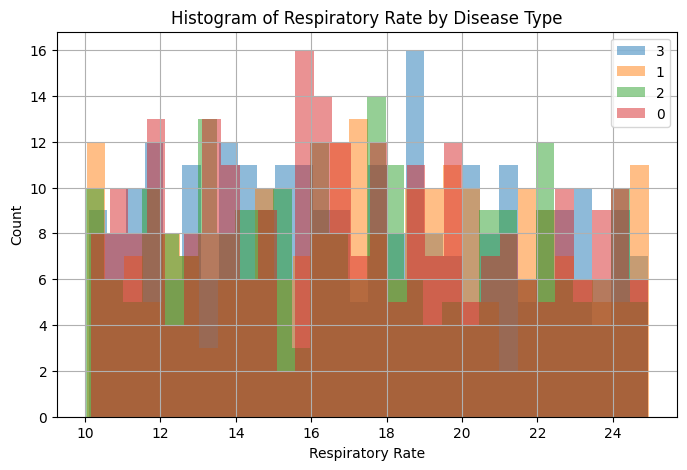

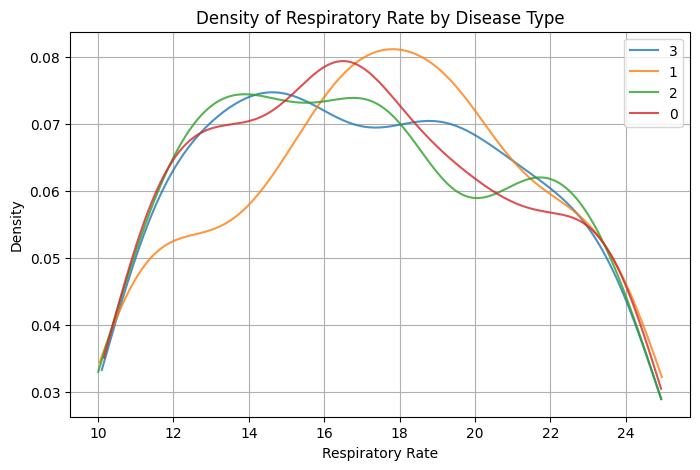

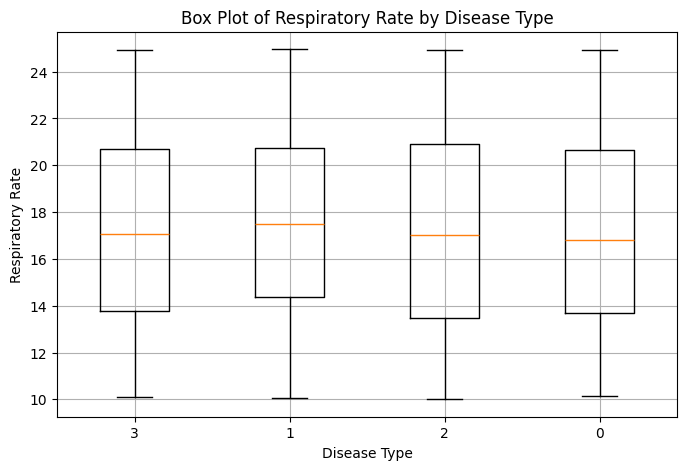

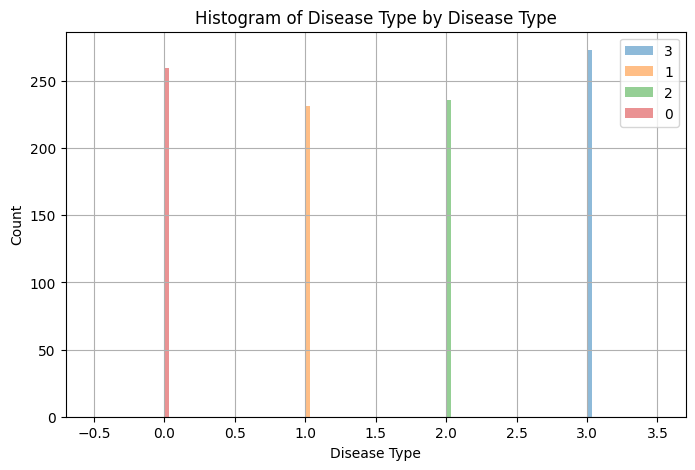

Skipping KDE plot for Disease Type, disease='3' due to singular data subset.
Skipping KDE plot for Disease Type, disease='1' due to singular data subset.
Skipping KDE plot for Disease Type, disease='2' due to singular data subset.
Skipping KDE plot for Disease Type, disease='0' due to singular data subset.


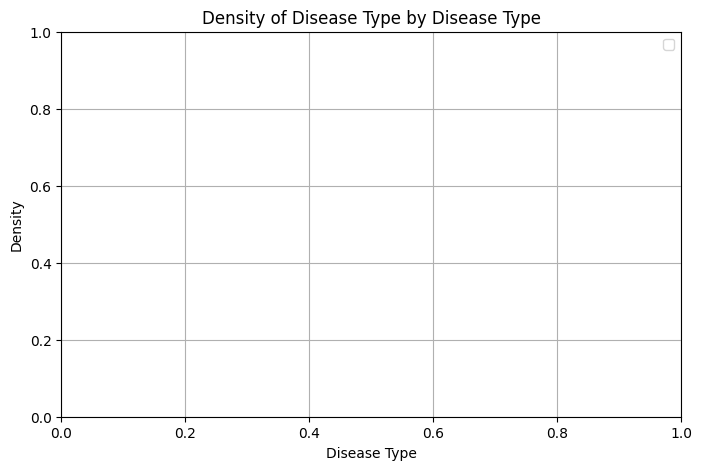

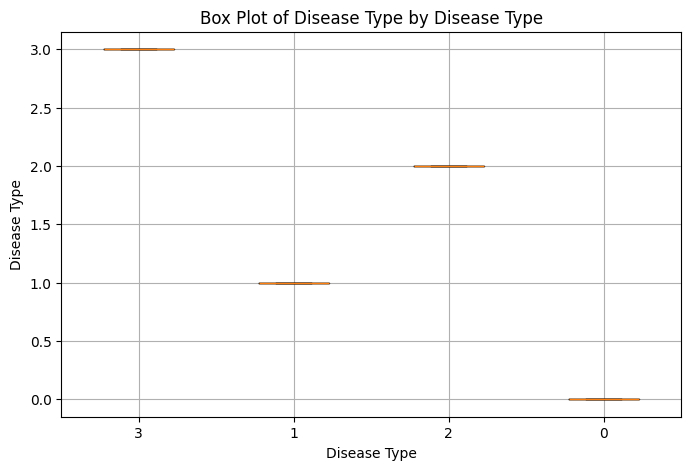

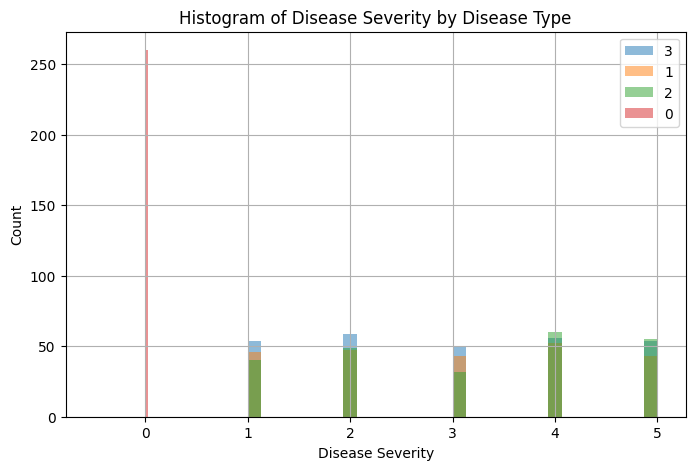

Skipping KDE plot for Disease Severity, disease='0' due to singular data subset.


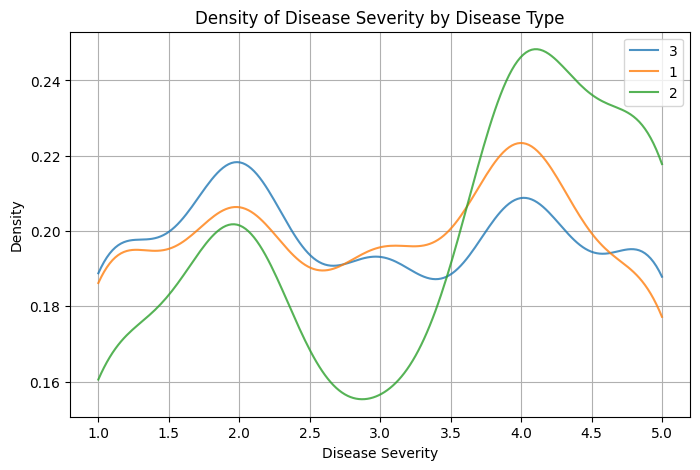

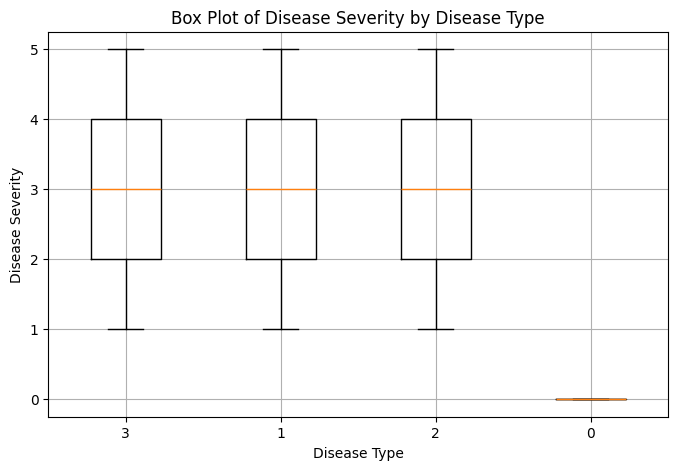

Summary statistics:
                Age       Height       Weight  Average Systolic  \
count  1000.000000  1000.000000  1000.000000       1000.000000   
mean     54.159000   174.396216    86.905721        139.818995   
std      20.277843    20.072441    24.272774         34.837371   
min      18.000000   140.045737    45.002611         80.470205   
25%      36.000000   156.658574    65.961394        109.430553   
50%      54.000000   174.068854    86.625773        138.516500   
75%      71.000000   191.724173   107.756616        170.457628   
max      89.000000   209.969039   129.808698        199.935282   

       Average Diastolic   Pulse Rate  Respiratory Rate  Disease Type  \
count        1000.000000  1000.000000       1000.000000   1000.000000   
mean           89.459032    79.110664         17.302316      1.522000   
std            23.170093    17.096463          4.191492      1.147533   
min            50.019280    50.014576         10.006154      0.000000   
25%            69.2

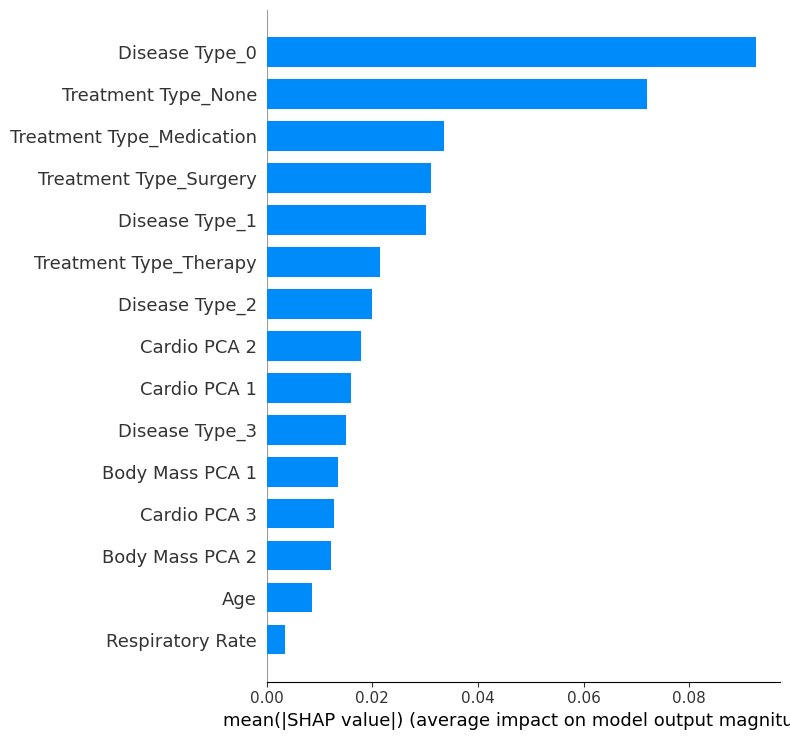

SHAP values shape: (100, 15)
Sample data shape: (100, 15)


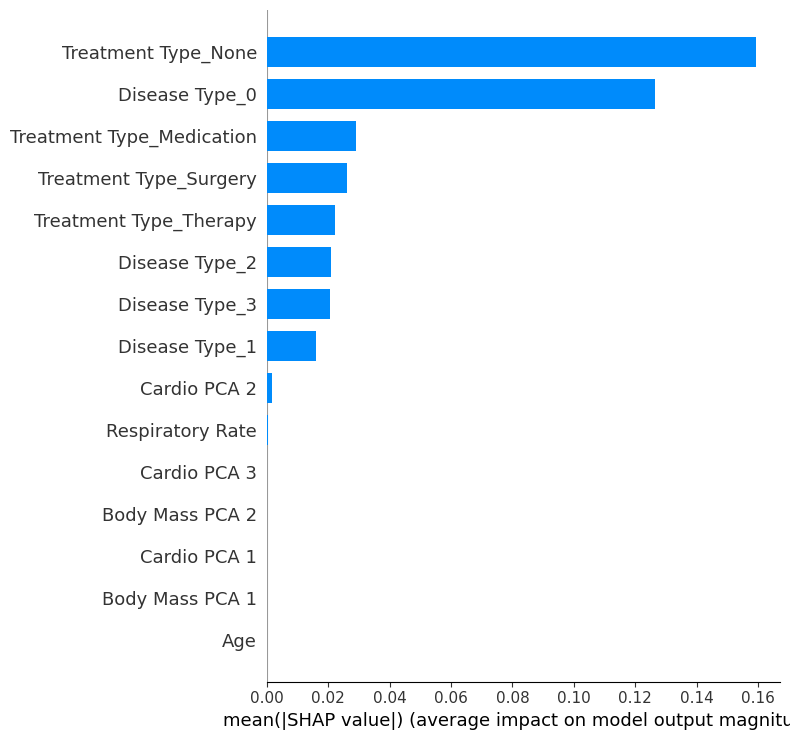

SHAP values shape: (100, 15)
Sample data shape: (100, 15)


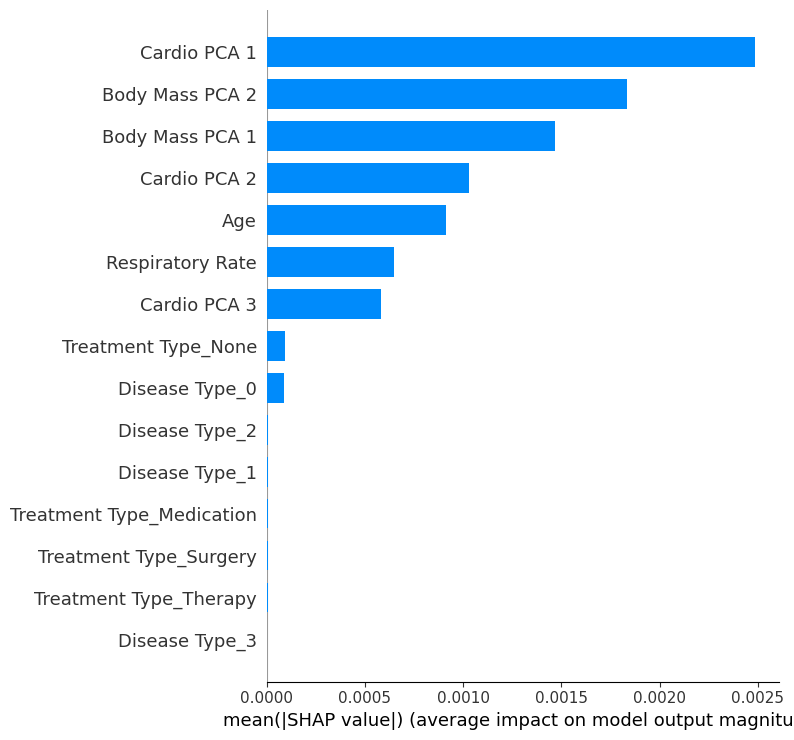

name,Ran?,Elapsed (s),Percentage
generate_data,True,0.235208,0.0164963
explore_data,True,29.4649,2.06652
reduce_dim,True,0.222709,0.0156197
run_pipeline_nn,True,0.700525,0.0491312
run_pipeline_rf,True,1.00597,0.0705533
run_pipeline_sv,True,0.606671,0.0425488
extract_features_nn,True,53.2509,3.73474
extract_features_rf,True,169.489,11.8871
extract_features_sv,True,1170.85,82.1173


In [8]:
import logging
logging.getLogger("shap").setLevel(logging.WARNING)
logging.getLogger("ploomber").setLevel(logging.WARNING)

# Build (execute) the entire pipeline.
dag.build()

## Inspect Outputs

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


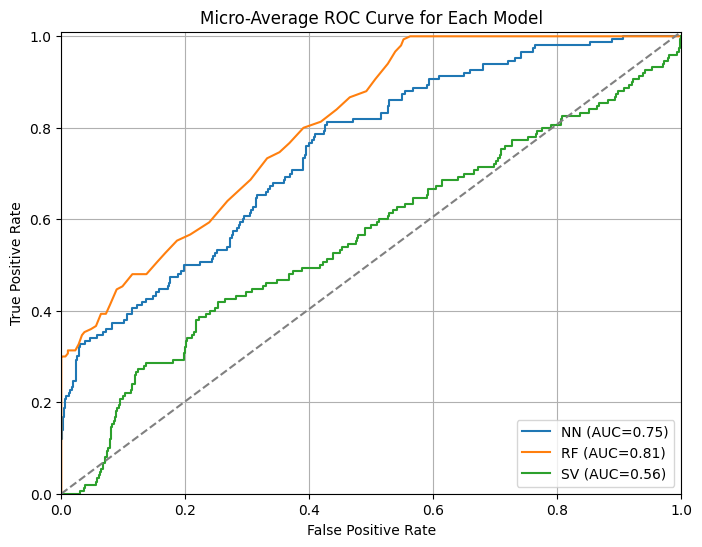

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import pickle  # Ensure pickle is imported

model_names = ["NN", "RF", "SV"]  # The same model names used in your pipeline

plt.figure(figsize=(8, 6))

for name in model_names:
    with open(f"results_{name.lower()}.pkl", "rb") as f:
        res = pickle.load(f)

    model = res["model"]
    X_test, y_test = res["test_data"]  # X_test is a NumPy array, y_test is a NumPy array

    # Convert X_test to a DataFrame using the stored final feature names
    if "final_feature_names" not in res:
        raise KeyError("final_feature_names not found in results. Ensure your pipeline saves them.")
    X_test = pd.DataFrame(X_test, columns=res["final_feature_names"])

    # Binarize the target for multi-class ROC computation.
    # Assume severity is on a scale 0 to 5.
    y_test_bin = pd.get_dummies(y_test)
    expected_classes = [0, 1, 2, 3, 4, 5]
    y_test_bin = y_test_bin.reindex(columns=expected_classes, fill_value=0)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        print(f"{name} does not support predict_proba; skipping.")
        continue

    # Compute micro-average ROC curve and AUC
    # Flatten both arrays so that all classes are aggregated.
    fpr, tpr, _ = roc_curve(y_test_bin.values.ravel(), y_pred_proba.ravel())
    auc_val = roc_auc_score(y_test_bin, y_pred_proba, average="micro")

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.2f})")

# Plot the diagonal reference line.
plt.plot([0, 1], [0, 1.01], '--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Average ROC Curve for Each Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Examine the Final Pipeline

In [10]:
from ploomber import DAG
from ploomber.tasks import PythonCallable
from ploomber.products import File
import graphviz

# Assuming you already have a DAG instance called 'dag'
dot = graphviz.Digraph(comment="Ploomber Pipeline")

# Add nodes for each task using task names from the DAG.
for task_name in dag:
    task_obj = dag[task_name]
    dot.node(task_name)

# Iterate over tasks to add edges with product labels.
for task_name in dag:
    task_obj = dag[task_name]
    for upstream_task_name, dependency in task_obj.upstream.items():
        if hasattr(dependency, "product"):
            product_str = str(dependency.product)
        else:
            product_str = "No product"
        dot.edge(upstream_task_name, task_name, label=product_str)

# Render the graph to a PNG file and save it to disk.
# Setting view=False prevents automatic opening of the file.
output_path = dot.render("ploomber_pipeline_structure_with_intermediates", view=False, format="png")
print("Pipeline diagram saved to:", output_path)


Pipeline diagram saved to: ploomber_pipeline_structure_with_intermediates.png
